## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2024.

# Assignment 1, Task 2: Multi-Layer Perceptron (MLP)

You will get to know how to build basic fully connected (FC) neural network. In this task, all the functions will be created from scratch using NumPy for your understanding. You will be introduced to built-in layers from TensorFlow in Task 3.

In [3]:
# Import modules
import tensorflow as tf
import time
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import fashion_mnist

# Plot configurations
%matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

## Load Data

In [5]:
# Load the raw Fashion-MNIST data.
train, test = fashion_mnist.load_data()

X_train_raw, y_train = train
X_test_raw, y_test = test

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

# Data organizations:
# Train data: 49000 samples from original train set: 1~49,000
# Validation data: 1000 samples from original train set: 49,000~50,000
# Test data: 10000 samples from original test set: 1~10,000
# Development data (for gradient check): 100 from the train set: 1~49,000
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(49000, 784) (1000, 784) (10000, 784) (100, 784)
Train data shape:  (49000, 784)
Train labels shape:  (49000,)
Validation data shape:  (1000, 784)
Validation labels shape:  (1000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)
Development data shape: (100, 784)
Development data shape (100,)


## Part 1: Basic Layers (15%)

A neural network layer needs two different passes in order to function properly:
- **Forward Pass**: computes the outputs given inputs
- **Backward Pass**: computes the gradients w.r.t. inputs and parameters from the outputs

In this part, we will implement both passes for several typical MLP components, which includes the **affine layer** (to generate linear embeddings of the inputs) and the **activation layer** (to provide non-linearity). Then we will implement the **Cross-Entropy Layer**, which is a one of the most popular classification loss.

### Affine Layer

Consider some input $X \in R^{N \times D}$ (from the previous layer), the forward pass of an affine layer with weight $W \in R^{D \times M}$ and bias $b \in R^M$ is defined as

$$Y = X W + \mathbb{1} b^T \in R^{N \times M}$$

During model training, we seek to update the parameters in order to decrease the loss. This requires the gradient of the loss $L$ w.r.t. the layer parameters $W$ and $b$. Assume that the gradient of $L$ w.r.t. the layer output $Y$ is given as

$$\nabla_Y L = G \in R^{N \times M}$$

The gradients of $L$ w.r.t. $W$ and $b$ can be computed as

$$
\begin{cases}
\nabla_W L = X^T G \in R^{D \times M} \\
\nabla_b L = \mathbb{1}^T G \in R^M
\end{cases}
$$

For other layers preceeding the current one, we would also want to update their parameters with the help of the gradients w.r.t. their output, which is our input $X$. It writes similarly that

$$\nabla_X L = G W^T \in R^{N \times D}$$

For those who are interested in how the equations are formulated, refer to http://cs231n.stanford.edu/handouts/linear-backprop.pdf.

An important observation is that the calculation of the gradients of the current layer depends on the **upstream gradients** (i.e. $\nabla_Y L$) from the layer afterwards. One needs to calculate the gradient of the loss value w.r.t. each parameter from the final output layer all the way back to the very beginning. This process is called **back-propagation**.

<font color="red"><strong>TODO</strong></font>: Complete the functions `affine_forward`, `affine_backward` in `./utils/layer_funcs.py`. 

<font color="red"><strong>NOTE</strong></font>: Please do not change the code in the cell below. The cell below will run correctly if your code is right.

In [25]:
# THE FOLLOWING IS THE VERIFICATION CODE
# DO NOT CHANGE IT.

from utils.layer_funcs import affine_forward
from utils.layer_funcs import affine_backward

# Generate data for checking
x = X_dev
w = np.random.rand(x.shape[1],100)
b = np.random.rand(100)
dout = np.ones((x.shape[0],100))

## Affine function: H = W*X + b
out = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, x, w, b)

## Check your implementation using the tf.gradients_function()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')

def affine_layer(x, w, b):
    return tf.matmul(x, w) + b

with tf.GradientTape() as tape:
    tape.watch(w_tf)
    out_tf = affine_layer(x_tf, w_tf, b_tf)
    dx_tf, dw_tf, db_tf = tape.gradient(out_tf, (x_tf, w_tf, b_tf))

out_check = out_tf.numpy()
dx_check, dw_check, db_check = dx_tf.numpy(), dw_tf.numpy(), db_tf.numpy()

## Print validation results
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


### ReLU Layer

Non-linearity is crucial for neural networks in their capabilities to learn and represent complex data. Mathematically, cascading linear maps are essentially equivalent to a single linear map, which is why we seek to inject non-linear functions between them. One of the simplest is ReLU (Rectified Linear Unit).

Consider the following function that admits a scaler input $x$. The forward pass of `ReLU` is defined as

$$y = \max (x, 0)$$

This is an element-wise mapping that can be propagated to arbitrary dimensions. The function mimics the activation mechnism of biological neurons which suppress negative inputs and pass through positive ones.

The backward pass is fairly straight forward. Assume that the gradient of loss $L$ w.r.t. the layer output $y$ is given as

$$\nabla_y L = g \in R$$

Since this layer is non-parametric (no internal parameters), we only care about the gradients of $L$ w.r.t. layer input $x$, which writes

$$
\nabla_x L = \begin{cases}
g & \quad \text{if } x > 0 \\
0 & \quad \text{otherwise}
\end{cases}
$$

<font color="red"><strong>TODO</strong></font>: Complete the functions `relu_forward`, `relu_backward` in `./utils/layer_funcs.py`.

<font color="red"><strong>NOTE</strong></font>: Please do not change the code in the cell below. The cell below will run correctly if your code is right.

In [27]:
# THE FOLLOWING IS THE VERIFICATION CODE
# DO NOT CHANGE IT.

from utils.layer_funcs import relu_forward
from utils.layer_funcs import relu_backward

## Activation layers -- Here we introduce ReLU activation function
## since it is the most commonly used in computer vision problems.
## However, you can also try to implement 
## other activation functions like sigmoid, tanh etc.
x = X_dev
dout = np.ones(x.shape)

## ReLU
out = relu_forward(x)
dx = relu_backward(dout, x)

## Check by tf.GradientTape.gradients()
x_tf = tf.Variable(x, name='x')
with tf.GradientTape() as tape:
    tape.watch(x_tf)
    out_tf = tf.nn.relu(x_tf)
    grad_gt = tape.gradient(out_tf, x_tf)

out_check = out_tf.numpy()
dx_check = grad_gt.numpy()
## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))

Is out correct? True
Is dx correct? True


### Tanh Layer

Another commonly used non-linear activation function is `tanh` (hyperbolic tangent), which is defined as:

$$
y = \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
$$

This function maps input values to a range between -1 and 1, helping to center the data. The `tanh` activation is particularly useful when negative values are significant, as it outputs both positive and negative values.

For the backward pass, given a gradient $g$ with respect to the output $y$, the gradient with respect to the input $x$ is:

$$
\nabla_x L = g \cdot (1 - y^2)
$$

This derivative shows how the gradients flow through the `tanh` activation, modulating the learning process.

<font color="red"><strong>TODO</strong></font>: Complete the functions `tanh_forward`, `tanh_backward` in `./utils/layer_funcs.py`.

<font color="red"><strong>NOTE</strong></font>: Please do not change the code in the cell below. The cell below will run correctly if your code is right.

In [29]:
# THE FOLLOWING IS THE VERIFICATION CODE
# DO NOT CHANGE IT.

from utils.layer_funcs import tanh_forward
from utils.layer_funcs import tanh_backward

## Activation layers -- Here we introduce the tanh activation function.
x = X_dev
dout = np.ones(x.shape)

## Tanh
out = tanh_forward(x)
dx = tanh_backward(dout, x)

## Check by tf.GradientTape.gradients()
x_tf = tf.Variable(x, name='x')
with tf.GradientTape() as tape:
    tape.watch(x_tf)
    out_tf = tf.nn.tanh(x_tf)
    grad_gt = tape.gradient(out_tf, x_tf)

out_check = out_tf.numpy()
dx_check = grad_gt.numpy()

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))

Is out correct? True
Is dx correct? True


### Softmax Cross-entropy Layer

Loss functions are real-valued function which represent measurements of how far the model predictions are away from the ground truths. Usually in classification tasks, both the predictions and the ground-truths are given as discrete $K$-dimensional distributions (corresponds to $K$ different classes).

As you may recall from task 1, a measure of dissimilarity can be given by the cross-entropy. We provided in task 1 a more detailed explaination so here we simply present the formulas.

Recall the softmax function

$$\sigma (x) = \frac{e^{x}}{\sum_i e^{x_i}}: R^K \to (0, 1)^K$$

and the cross entropy function

$$H(p, q) = -p^T \log q: R^K \to R$$

Assume the predictions $Y \in R^{N \times K}$ ($y_i \in R^K$ is the predicted logit over all classes in $R^K$ for the $i$-th data sample) and the ground truth $G \in R^{N \times K}$ ($g_i \in R^K$ is the corresponding one-hot encoding of the ground truth class). The forward pass of softmax cross-entropy loss is defined as

$$L = \frac{1}{N} \sum_i H(g_i, \sigma (y_i))$$

And the backward pass is

$$\nabla_Y L = \frac{1}{N} (\sigma (Y) - G)$$

<font color="red"><strong>TODO</strong></font>: Complete the functions `softmax_loss` in `./utils/layer_funcs.py`.

<font color="red"><strong>NOTE</strong></font>: Please do not change the code in the cell below. The cell below will run correctly if your code is right.

In [31]:
# THE FOLLOWING IS THE VERIFICATION CODE
# DO NOT CHANGE IT.

from utils.layer_funcs import softmax_loss

## Generate some random data for testing
x = np.random.rand(100, 10)
y = np.argmax(x, axis=1)

loss, dx = softmax_loss(x, y)

## Check by tf.GradientTape.gradients()

x_tf = tf.Variable(x, name='x')
y_tf = tf.Variable(y, name='y')

with tf.GradientTape() as tape:
    tape.watch(x_tf)
    loss_tf = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=x_tf, labels=tf.one_hot(y_tf, 10)))
    dx_tf = tape.gradient(loss_tf, x_tf)

loss_check = loss_tf.numpy()
dx_check = dx_tf.numpy()
## Print validation result
print("Is loss correct? {}".format(np.allclose(loss, loss_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))

Is loss correct? True
Is dx correct? True


### Create a single layer

In this section, we are going to implement an **affine layer** and then a **dense layer** on top of that. 

* input >> AffineLayer >> output

```
    class AffineLayer:
        __init__:
            params - weights and bias
            cache - intermeidate results for back propagation
            gradients - gradients of the parameters for optimization
        feedforward: forward pass
        backward: backward pass
        update_layer: update layer parameters
```

* input >> AffineLayer >> ReLU >> output

```
    class DenseLayer:
        __init__:
            affine - an affine layer
            activation: activation function
        feedforward: forward pass
        backward: backward pass
        update_layer: update layer parameters
```

<font color="red"><strong>TODO</strong></font>: Complete function `AffineLayer` in `./utils/layer_utils.py`.

<font color="red"><strong>NOTE</strong></font>: Please do not change the code in the cell below. The cell below will run correctly if your code is right.

In [41]:
# THE FOLLOWING IS THE VERIFICATION CODE
# DO NOT CHANGE IT.

from utils.layer_utils import AffineLayer

## Affine
test_affine = AffineLayer(input_dim=X_train.shape[1], output_dim=100)
w, b = test_affine.params['W'], test_affine.params['b']

## Data for correctness check
x = X_dev
dout = np.ones((x.shape[0], 100))

out = test_affine.feedforward(x)
dx = test_affine.backward(dout)
dw, db = test_affine.gradients['W'], test_affine.gradients['b']

## Check by tf.GradientTape.gradients()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')

def affine_layer(x, w, b):
    return tf.matmul(x, w) + b

with tf.GradientTape() as tape:
    tape.watch(w_tf)
    out_tf = affine_layer(x_tf, w_tf, b_tf)
    dx_tf, dw_tf, db_tf = tape.gradient(out_tf, (x_tf, w_tf, b_tf))

out_check = out_tf.numpy()
dx_check = dx_tf.numpy()
dw_check = dw_tf.numpy()
db_check = db_tf.numpy()

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


<font color="red"><strong>TODO</strong></font>: Complete function `DenseLayer` in **./utils/layer_utils.py**

<font color="red"><strong>NOTE</strong></font>: Please do not change the code in the cell below. The cell below will run correctly if your code is right.

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


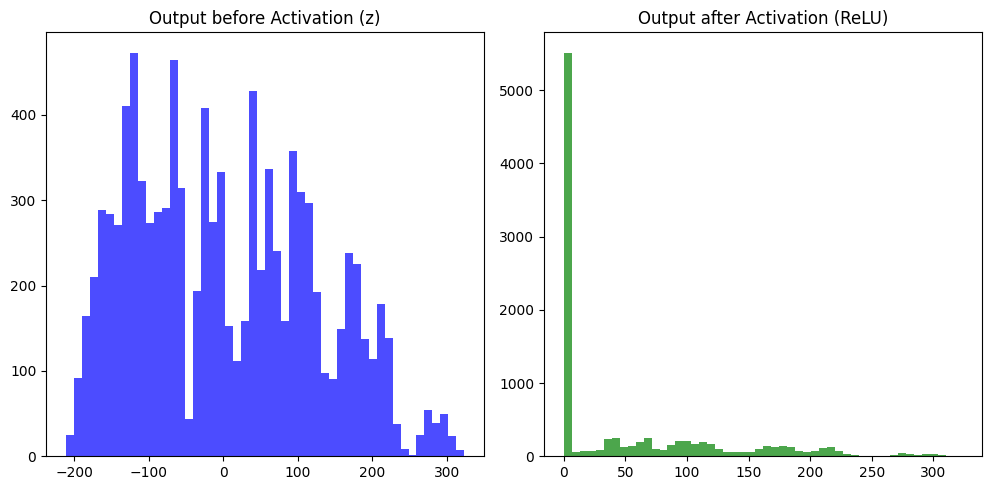

In [53]:
# THE FOLLOWING IS THE VERIFICATION CODE
# DO NOT CHANGE IT.

## First, let's make a dense layer
from utils.layer_utils import DenseLayer

## Affine + ReLU
test_dense = DenseLayer(input_dim=X_train.shape[1], output_dim=100)
w, b = test_dense.params['W'], test_dense.params['b']

## Data for correctness check
x = X_dev
dout = np.ones((x.shape[0], 100))

z = x.dot(w) + b

out = test_dense.feedforward(x)
dx = test_dense.backward(dout)
dw, db = test_dense.gradients['W'], test_dense.gradients['b']

## Check by tf.GradientTape.gradients()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')

def dense_layer(x, w, b):
    return tf.nn.relu(tf.matmul(x, w) + b)

with tf.GradientTape() as tape:
    tape.watch(w_tf)
    out_tf = dense_layer(x_tf, w_tf, b_tf)
    dx_tf, dw_tf, db_tf = tape.gradient(out_tf, (x_tf, w_tf, b_tf))

out_check = out_tf.numpy()
dx_check = dx_tf.numpy()
dw_check = dw_tf.numpy()
db_check = db_tf.numpy()

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

# Visualization

# Plot the output before and after activation
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(z.flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Output before Activation (z)')

plt.subplot(1, 3, 2)
plt.hist(out.flatten(), bins=50, color='green', alpha=0.7)
plt.title('Output after Activation (ReLU)')

plt.tight_layout()
plt.show()

<font color="red"><strong>TODO</strong></font>: What do you observe from the figure?

   Your answer: **[fill in here]**

## Part 2: Two Layer Network (15%)

Complete the class `TwoLayerNet` in `./utils/classifiers/twolayernet.py`. Through this experiment, you will create a two-layer neural network and learn about the backpropagation mechanism. The network structure is like 

* input >> DenseLayer >> AffineLayer >> softmax loss >> output

```
    class TwoLayerNet:
        __init__: 
            - layers: a dense layer and an affine layer
        forward: forward pass
        loss: cross entropy loss and gradients
        step: a single step update of all weights and bias by SGD.
        predict: output result (classification accuracy) based on input data
        save_model: return the parameters of the network
        update_model: update model weights (by calling layer.update_layer)
```

You will use two different optimization algorithms - **SGD** and **SGD with momentum**. A comparison between them is as follows:

* Stochastic gradient descent - SGD

$$w \gets w - \alpha \nabla_w L$$

* SGD with momentum

$$v \gets \beta v + \alpha \nabla_w L,\quad w \gets w - v$$

where $\alpha$ is the learning rate (step size) and $\beta$ is the momentum. 

<font color="red"><strong>TODO</strong></font>: Complete class `TwoLayerNet` in `./utils/classifiers/twolayernet.py`.

<font color="red"><strong>NOTE</strong></font>: Please do not change the code in the cell below. The cell below will run correctly if your code is right.

In [63]:
# THE FOLLOWING IS THE VERIFICATION CODE
# DO NOT CHANGE IT.

from utils.classifiers.twolayernet import TwoLayerNet

## Define a model
model = TwoLayerNet(input_dim=X_train.shape[1], hidden_dim=100, num_classes=20, reg=1e-4)
W1, b1 = model.layer1.params['W'], model.layer1.params['b']
W2, b2 = model.layer2.params['W'], model.layer2.params['b']
## Feedforward
y_score = model.forward(X_dev)
## Backprogation -- Finish loss function and gradients calculation in TwoLayerNet
loss = model.loss(y_score, y_dev)
pred = model.predict(X_dev)

## Check loss by tensorflow
x_tf = tf.Variable(X_dev, dtype=tf.float32)
y_tf = tf.Variable(y_dev, dtype=tf.uint8)

W1_tf = tf.Variable(W1.astype('float32'))
b1_tf = tf.Variable(b1.astype('float32'))
W2_tf = tf.Variable(W2.astype('float32'))
b2_tf = tf.Variable(b2.astype('float32'))
h1_tf = tf.nn.relu(tf.matmul(x_tf, W1_tf))
h2_tf = tf.matmul(h1_tf, W2_tf) + b2_tf
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=h2_tf, labels=tf.one_hot(y_tf, 20))
L2_loss = tf.nn.l2_loss(W1_tf) + tf.nn.l2_loss(W2_tf)
loss_tf = tf.reduce_mean(cross_entropy) + 1e-4 * L2_loss
pred_tf = tf.argmax(h2_tf, axis=-1)

loss_check = loss_tf.numpy()
pred_check = pred_tf.numpy()

## Print validation result
print("Is loss correct? {}".format(np.allclose(loss, loss_check)))
print("Is prediction correct? {}".format(np.allclose(pred, pred_check)))

NotImplementedError: 

### Train a two-layer network

#### Import functions for training and testing

In [55]:
from utils.train_funcs import train, test

#### Start training
We have provide you the `train` function in **./utils/train_func.py**

In [57]:
# THE FOLLOWING IS THE VERIFICATION CODE     #
# DO NOT CHANGE IT.                        #

from utils.classifiers.twolayernet import TwoLayerNet

## TODO: Use previous layers to create a two layer neural network
## input->(affine->activation)->(affine->softmax)->output
## The recommended activation function is ReLU. And you can 
## also make a comparison with other activation function to see
## any difference.
model = TwoLayerNet(input_dim=X_train.shape[1], hidden_dim=400, num_classes=20, reg=1e-4, weight_scale=1e-3)

num_epoch = 10
batch_size = 500
lr = 5e-4
verbose = True
train_acc_hist, val_acc_hist = train(
    model, X_train, y_train, X_val, y_val, num_epoch=num_epoch, batch_size=batch_size, 
    learning_rate=lr, verbose=verbose
)
test(model, X_test, y_test)

number of batches for training: 98


ModuleNotFoundError: No module named 'layer_funcs'

<font color="red"><strong>TODO</strong></font>: Plot training and validation accuracy history of each epoch. Remember to add a legend. 

In [ ]:
## TODO: Plot the accuracy history

############################################################################
#                         START OF YOUR CODE                               #
############################################################################



############################################################################
#                          END OF YOUR CODE                                #
############################################################################

#### Visulize the weight variable in the first layer.

Visualization of the intermediate weights can help you get an intuitive understanding of how the network works, especially in  Convolutional Neural Networks (CNNs).

In [ ]:
from utils.display_funcs import visualize_pics

In [ ]:
weights = model.layer1.params['W']
pics = weights.reshape(1, X_train_raw.shape[1], X_train_raw.shape[2], -1).transpose(3, 1, 2, 0)
## Visualization
visualize_pics(pics, cmap='nipy_spectral')

### Get test accuracy greater than 80%

For this part, you need to train a better two-layer net. The requirement is to get test accuracy better than 80%. If your accuracy is lower, for each 1% lower than 80%, you will lose 1 point (There are totally 10 points for this part).

Here are some recommended methods for improving the performance. Feel free to try any other method as you see fit.

1. Hyperparameter tuning: reg, hidden_dim, lr, learning_decay, num_epoch, batch_size, weight_scale.
2. Adjust training strategy: Randomly select a batch of samples rather than selecting them orderly. 
3. Try new optimization methods: Now we are using SGD, you can try SGD with momentum, adam, etc.
4. Early-stopping.
5. Good (better) initial values for weights in the model.

<font color="red"><strong>TODO:</strong></font> See below.

In [ ]:
from utils.classifiers.twolayernet import TwoLayerNet
# TODO: Use previous layers to create a two layer neural network.
# Try several solutions and report the best performing one.
# input->(affine->activation)->(affine->softmax)->output
# The recommended activation function is ReLU. You can 
# make a comparison with other activation functions to see
# the differences.
#
# You will need to execute code similar to the code below, using your parameter specs:
#    model = TwoLayerNet(input_dim=TBD, hidden_dim=TBD, num_classes=TBD, reg=TBD, weight_scale=TBD)
#    num_epoch = TBD
#    batch_size = TBD
#    lr = TBD
#    verbose = TBD
#    train_acc_hist, val_acc_hist = train(TBD)
#    test(TBD, TBD, TBD)


############################################################################
#                         START OF YOUR CODE                               #
############################################################################



############################################################################
#                          END OF YOUR CODE                                #
############################################################################

#### <font color="red"><strong>TODO</strong></font>: Show your best result, including accuracy and weights of the first layer

In [ ]:
## TODO: Plot training and validation accuracy

############################################################################
#                         START OF YOUR CODE                               #
############################################################################



############################################################################
#                          END OF YOUR CODE                                #
############################################################################

In [ ]:
## TODO: Visualize weights

############################################################################
#                         START OF YOUR CODE                               #
############################################################################



############################################################################
#                          END OF YOUR CODE                                #
############################################################################

### Save Your Best Model in a Dictionary 

In [ ]:
## Create "save_model" folder if it does not exist
save_dir = "./save_models/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

## Save your model
save_params = model.save_model()
with open("./save_models/best_model.pkl", "wb") as output_file:
    pickle.dump(save_params, output_file)

In [ ]:
## Load your model
with open("./save_models/best_model.pkl", "rb") as input_file:
   loaded_model = pickle.load(input_file)

model = TwoLayerNet(input_dim=X_train.shape[1], hidden_dim=300, num_classes=20)
model.update_model(loaded_model)

## Part 3: Multilayer Network (10%)

Complete the class `MLP` in `./utils/classifiers/mlp.py`. It should allow arbitrary settings for the number of hidden layers as well as the number of hidden neurons in each layer. `MLP` has a similar structure as a `TwoLayerNet` network.

```
class MLP:
    functions: __init__, loss, step, predict, check_accuracy
    variables: layers
```

<font color="red"><strong>TODO</strong></font>: Complete the class `MLP` in `./utils/classifiers/mlp.py`.

<font color="red"><strong>NOTE</strong></font>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [ ]:
# THE FOLLOWING IS THE VERIFICATION CODE
# DO NOT CHANGE IT.

from utils.classifiers.mlp import MLP

## Use a sequence of layers to create a multiple layer neural network
## input->(affine->activation)-> ... ->(affine->activation)->(affine->softmax)->output
model = MLP(input_dim=X_train.shape[1], hidden_dims=[200, 100], num_classes=20, reg=0.5, weight_scale=1e-3)

num_epoch = 10
batch_size = 128
lr = 5e-3
verbose = False
train_acc_hist, val_acc_hist = train(
    model, X_train, y_train, X_val, y_val, 
    num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, 
    optim='SGD', momentum=0.9, verbose=verbose
)
test(model, X_test, y_test)

<font color="red"><strong>TODO</strong></font>: Plot training and validation accuracy history of each epoch

In [ ]:
#TODO: plot training and validation accuracy

############################################################################
#                         START OF YOUR CODE                               #
############################################################################



############################################################################
#                          END OF YOUR CODE                                #
############################################################################